In [13]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K
from tcn import TCN
from keras import regularizers

# Import data

In [1]:
training_df_raw=pd.read_csv("0.5s_raw_range_A1_A2_A3_no_overlap.csv")
#training_df=pd.read_csv("0.5s_spec_range_A1_A2_A3_no_overlap.csv")

NameError: name 'pd' is not defined

# Classification with raw data

In [3]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
raw_x_data=[]
raw_y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    else:
        class_val=3
    return class_val

def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice or full_name in good_runs_phantom or full_name in good_runs_IF:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250 and  not(38<np.array(dist)[0]<42) and not(58<np.array(dist)[0]<62) and not(78<np.array(dist)[0]<82) :
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(data)
                        range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            raw_x_data.extend(np.array(twd_frame))
            raw_y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3


KeyboardInterrupt: 

In [592]:
def subsample_raw(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x]==3 and rand_vals[0]==2:
        #if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
raw_x_data=np.array(raw_x_data)
raw_x_data=np.float32(raw_x_data)
raw_y_data=np.array(raw_y_data)
x_raw,y_raw=subsample_raw(raw_x_data,raw_y_data)
train_feats_raw,test_feats_raw,train_targs_raw,test_targs_raw=train_test_split(x_raw,y_raw,test_size=0.2,shuffle=True,random_state=42)
range_train_targs_raw=train_targs_raw[:]
range_train_targs_oh_raw=tf.keras.utils.to_categorical(range_train_targs_raw,num_classes=4)
range_test_targs_raw=test_targs_raw[:]
range_test_targs_oh_raw=tf.keras.utils.to_categorical(range_test_targs_raw,num_classes=4)

(array([7631.,    0.,    0., 4452.,    0.,    0., 5298.,    0.,    0.,
        6802.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

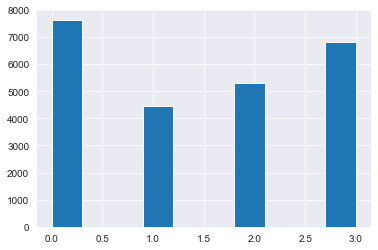

In [593]:
plt.hist(y_raw)

In [594]:
from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(class_train_targs), y=class_train_targs)
# class_weights={0:class_weights[0], 1:class_weights[1]}
#print(class_weights)
range_weights_raw=class_weight.compute_class_weight('balanced', classes=np.unique(range_train_targs_raw), y=range_train_targs_raw)
#,4:range_weights[4],5:range_weights[5], 6:range_weights[6]
range_weights_raw={0:range_weights_raw[0], 1:range_weights_raw[1],2:range_weights_raw[2], 3:range_weights_raw[3]}
print(range_weights_raw)

{0: 0.7917007693566869, 1: 1.3524888143176734, 2: 1.1337318330989217, 3: 0.8964782205746061}


# From raw audio data (0.5s frames) to spectrogram dataset (Classification)

In [4]:
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
x_data=[]
y_data=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_IF:
        drone_type=1
    elif full_name in good_runs_matrice:
        drone_type=0
    else:
        drone_type=2
    if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom:
    #if full_name in good_runs_phantom:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
                #data=np.array(frame_df.iloc[:,8:16008])
                if np.any(data):
                    mel_data=melspect(data[0],8000)
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250 and  not(38<np.array(dist)[0]<42) and not(58<np.array(dist)[0]<62) and not(78<np.array(dist)[0]<82) :
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(mel_data)
                        range_frame.append([class_value,drone_type,dist])
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


In [48]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x][0]==3 and rand_vals[0]==2:
        #if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x][0] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
x_data=np.array(x_data)
x_data=np.float32(x_data)
y_data=np.array(y_data)
x__,y__=subsample(x_data,y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x__,y__,test_size=0.2,shuffle=True,random_state=42)
class_train_targs=train_targs[:,1]
cont_range_train_targs=train_targs[:,2]
range_train_targs=train_targs[:,0]
class_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=3)
range_train_targs_oh=tf.keras.utils.to_categorical(range_train_targs,num_classes=4)
class_test_targs=test_targs[:,1]
cont_range_test_targs=test_targs[:,2]
range_test_targs=test_targs[:,0]
class_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=3)
range_test_targs_oh=tf.keras.utils.to_categorical(range_test_targs,num_classes=4)

KeyboardInterrupt: 

# Split Training Dataset into the three sUAS Types (IF, Matrice, Phantom)

In [73]:
if_train_data=[]
if_test_data=[]
matrice_train_data=[]
matrice_test_data=[]
phantom_train_data=[]
phantom_test_data=[]
if_train_targs=[]
if_test_targs=[]
matrice_train_targs=[]
matrice_test_targs=[]
phantom_train_targs=[]
phantom_test_targs=[]
for x in range(len(train_targs)):
    if train_targs[x][1]==0:
        matrice_train_data.append(train_feats[x])
        matrice_train_targs.append(train_targs[x][0])
    elif train_targs[x][1]==1:
        if_train_data.append(train_feats[x])
        if_train_targs.append(train_targs[x][0])
    elif train_targs[x][1]==2:
        phantom_train_data.append(train_feats[x])
        phantom_train_targs.append(train_targs[x][0])

for x in range(len(test_targs)):
    if test_targs[x][1]==0:
        matrice_test_data.append(test_feats[x])
        matrice_test_targs.append(test_targs[x][0])
    elif test_targs[x][1]==1:
        if_test_data.append(test_feats[x])
        if_test_targs.append(test_targs[x][0])
    elif test_targs[x][1]==2:
        phantom_test_data.append(test_feats[x])
        phantom_test_targs.append(test_targs[x][0])

# Null model

In [172]:
correct=0
pred=0
total=0
rng=np.random.default_rng(12345)
for x in range(len(test_targs)):
    rand_vals=rng.integers(low=1,high=100,size=1)
    if rand_vals[0]<34:
        pred=0
    elif rand_vals[0]<50:
        pred=1
    elif rand_vals[0]<68:
        pred=2
    else:
        pred=3
    if(test_targs[x][0]==pred):
        correct+=1
    total+=1
correct/total

0.2649753347427766

In [150]:
from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(class_train_targs), y=class_train_targs)
# class_weights={0:class_weights[0], 1:class_weights[1]}
#print(class_weights)
range_weights=class_weight.compute_class_weight('balanced', classes=np.unique(phantom_train_targs), y=phantom_train_targs)
#,4:range_weights[4],5:range_weights[5], 6:range_weights[6]
range_weights={0:range_weights[0], 1:range_weights[1],2:range_weights[2], 3:range_weights[3]}
print(range_weights)

{0: 0.9723385167464115, 1: 1.2033678756476685, 2: 1.523664479850047, 3: 0.6737463738085371}


[ 0.          1.         31.91555911]


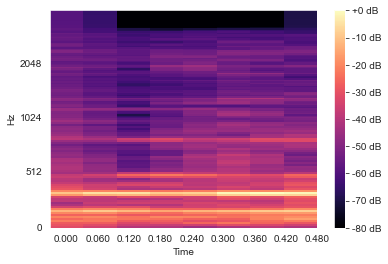

In [526]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(x_data[1500], ref=np.max)
print(y_data[1500])
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
plt.savefig("melspect.pdf")

# CNN for Classification (Best performing model)

In [ ]:
modelCNN_MCV2=tf.keras.Sequential()
modelCNN_MCV2.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MCV2.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(MaxPooling2D(2))
modelCNN_MCV2.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Flatten())
modelCNN_MCV2.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MCV2.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MCV2.add(Dropout(0.5))
modelCNN_MCV2.add(Dense(4, activation='softmax', name='output_range'))

optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV2.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV2.build(input_shape=(None,128,8,1))
modelCNN_MCV2.summary()
single_drone_train_targs_oh=tf.keras.utils.to_categorical(phantom_train_targs,num_classes=4)
single_drone_train_data=np.array(phantom_train_data)
history = modelCNN_MCV2.fit(single_drone_train_data, single_drone_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

In [113]:
MLtools.save_model(modelCNN_MCV2,"localization_CNNV2(best)_090222")

In [156]:
test_targs_oh=tf.keras.utils.to_categorical(phantom_test_targs,num_classes=4)
score = modelCNN_MCV2.predict(np.array(phantom_test_data))
modelCNN_MCV2.evaluate(np.array(phantom_test_data),y={'output_range':test_targs_oh})
#test_predictions=modelCNN_MCV2.predict(test_feats)

51/51 [==============================] - 0s 7ms/step - loss: 0.8734 - accuracy: 0.6516


[0.8733940720558167, 0.6515527963638306]

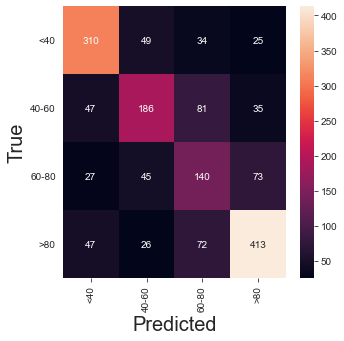

In [174]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(score,axis=-1)
y_true=np.argmax(test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

#plt.title('2DCNN Classification PhantomDS Confusion Matrix', fontsize=20)
plt.savefig("phantomds_confusion_CNNV2.pdf",bbox_inches='tight')

In [158]:
from sklearn.metrics import balanced_accuracy_score
print(classification_report(y_true=y_true,y_pred=y_pred))
print(balanced_accuracy_score(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       418
           1       0.61      0.53      0.57       349
           2       0.43      0.49      0.46       285
           3       0.76      0.74      0.75       558

    accuracy                           0.65      1610
   macro avg       0.63      0.63      0.63      1610
weighted avg       0.66      0.65      0.65      1610

0.62648738075193


# Evaluate Model on Each sUAS Type

In [105]:
single_drone_truth=[]
single_drone_pred=[]
for x in range(len(class_test_targs)):
    if class_test_targs[x]==2: #0 == Matrice, 1== IF, 2== Phantom
        single_drone_truth.append(np.argmax(range_test_targs_oh[x], axis=-1))
        single_drone_pred.append(np.argmax(test_predictions[x], axis=-1))
        cm = confusion_matrix(single_drone_truth, single_drone_pred)

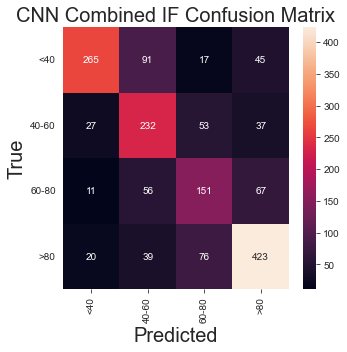

In [106]:
cm = confusion_matrix(single_drone_truth, single_drone_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CNN Combined IF Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.savefig("IF_CM.pdf")

In [104]:
print(classification_report(y_true=single_drone_truth,y_pred=single_drone_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       748
           1       0.61      0.68      0.64       265
           2       0.74      0.77      0.75       435
           3       0.85      0.83      0.84       625

    accuracy                           0.82      2073
   macro avg       0.78      0.79      0.79      2073
weighted avg       0.83      0.82      0.82      2073



# The rest of the blocks are other models that were rejected due to low performance (CRNN and 1DCNN)

# CRNN for Classification:

In [64]:
modelCRNN=tf.keras.Sequential()
modelCRNN.add(BatchNormalization(input_shape=(128,8,1)))
modelCRNN.add(Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
#modelCRNN.add(MaxPooling2D(2,2))
modelCRNN.add(Conv2D(filters=16,kernel_size=(4,4),strides=(2,1), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
modelCRNN.add(Dropout(0.3))
modelCRNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,1), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
modelCRNN.add(MaxPooling2D((12,1)))
modelCRNN.add(Dropout(0.3))
#modelCRNN.add(Flatten())
modelCRNN.add(Reshape((8,32),input_shape=(1,8,32)))
modelCRNN.add(GRU(32, input_shape=(1,8,32)))
modelCRNN.add(Dense(64, activation='relu', name='dense_3'))
modelCRNN.add(Dropout(0.5))
modelCRNN.add(Dense(4, activation='softmax', name='dense_4'))


optimizer= tf.keras.optimizers.Adam()
modelCRNN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,
                          patience=40, mode='auto', restore_best_weights=True)
modelCRNN.build(input_shape=(None,128,8,1))
modelCRNN.summary()
history = modelCRNN.fit(train_feats, range_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      class_weight=range_weights,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_79 (Bat  (None, 128, 8, 1)        4         
 chNormalization)                                                
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 8)         32        
                                                                 
 batch_normalization_80 (Bat  (None, 128, 8, 8)        32        
 chNormalization)                                                
                                                                 
 activation_60 (Activation)  (None, 128, 8, 8)         0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 8, 16)         2048      
                                                                 
 batch_normalization_81 (Bat  (None, 64, 8, 16)      

In [657]:
MLtools.save_model(modelCRNN,"localization_CRNN_083122")

# 1DCNN with Raw inputs

In [600]:
mean = train_feats_raw.mean(axis=0)
train_feats_raw -= mean
test_feats_raw -= mean
std = train_feats_raw.std(axis=0)
train_feats_raw /= std
test_feats_raw /= std
#train_feats_raw=np.reshape(train_feats_raw, (len(train_feats_raw), 4000, 1))
print(len(train_feats_raw))

ValueError: operands could not be broadcast together with shapes (4837,4000) (4000,1) (4837,4000) 

In [655]:
modelRaw=tf.keras.Sequential()
# This is actually >7 layers with the dilation and residual blocks
#modelRaw.add(TCN( nb_filters = 16, kernel_size=20, dilations=[1,8,32,64], name='tcn', input_shape=(4000,1)))
modelRaw.add(Conv1D(64,input_shape=[4000, 1],kernel_size=80,strides=4,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Conv1D(64,kernel_size=3,strides=2,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Dropout(0.3))
modelRaw.add(Conv1D(128,kernel_size=3,strides=1,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Conv1D(256, kernel_size=3,strides=1,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=2, strides=None))
modelRaw.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
modelRaw.add(Dense(4, activation='softmax'))
# modelRaw.add(Conv1D(16, kernel_size=20, padding = 'causal', dilation_rate=32, activation = 'relu', name='Conv5'))
# modelRaw.add(Conv1D(16, kernel_size=20, padding = 'causal', dilation_rate=64, activation = 'relu', name='Conv6'))
optimizer= tf.keras.optimizers.Adam()
modelRaw.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelRaw.build(input_shape=(None,4000,1))
modelRaw.summary()
history = modelRaw.fit(train_feats_raw, range_train_targs_oh_raw,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1000, 64)          5184      
                                                                 
 batch_normalization_650 (Ba  (None, 1000, 64)         256       
 tchNormalization)                                               
                                                                 
 activation_418 (Activation)  (None, 1000, 64)         0         
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 250, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 125, 64)           12352     
                                                                 
 batch_normalization_651 (Ba  (None, 125, 64)       

In [455]:
test_feasts_rs=np.reshape(test_feats, (len(test_feats), 4000, 1))
score = modelRaw.predict(test_feasts_rs)
modelRaw.evaluate(test_feasts_rs,range_test_targs_oh)

152/152 [==============================] - 11s 62ms/step - loss: 0.9310 - accuracy: 0.6190


[0.9309757947921753, 0.6189786791801453]

              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1522
           1       0.44      0.53      0.48       876
           2       0.54      0.47      0.51      1032
           3       0.67      0.71      0.69      1407

    accuracy                           0.62      4837
   macro avg       0.60      0.60      0.60      4837
weighted avg       0.63      0.62      0.62      4837



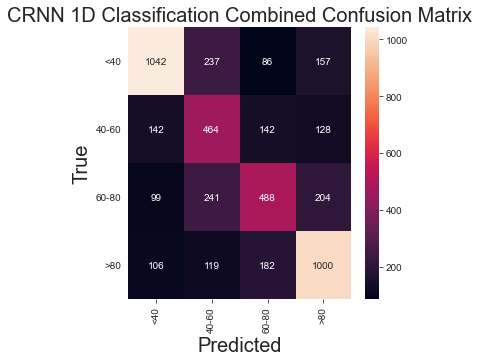

In [457]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(score,axis=-1)
y_true=np.argmax(range_test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CRNN 1D Classification Combined Confusion Matrix', fontsize=20)
print(classification_report(y_true=y_true,y_pred=y_pred)) #this is using the multi-output regression/classification
